In [1006]:
import torch
import torch.nn as nn
from torchsde import sdeint
import torchsde
import math
import random
from utils import _stable_division

In [1258]:
from fractional_noise_ import SparseGPNoise
class TrueNoise(SparseGPNoise):
    def compute_hurst(self, t):
        t = t.view(-1, 1)
        return torch.ones(1, 1) * torch.sigmoid((1.0 - t) * 7.0) * 0.5 + 0.3


def get_data():

    t0, t1 = 0.0, 2.0
    batch_size = 200

    x0 = 1.0
    alpha = 0.5
    beta = 0.5
    true_wn = TrueNoise(t0=t0, t1=t1, dt=1e-2, num_steps=500, num_inducings=50)

    true_wn.precompute(batch_size=200)

    ts, B_h, _ = true_wn.sample_alternative(200)

    ht = torch.stack(
        [true_wn.compute_hurst(t) for t in ts], dim=0
    )  # t_size, 1, state_size

    # the exact solution
    X_t = x0 * torch.exp(
        beta * B_h
        - 0.5 * beta**2 * ts.reshape(-1, 1, 1) ** (2 * ht)
    )
    X_t = X_t.squeeze().transpose(0, 1)

    return ts, X_t, ht

In [673]:
batch_size, state_size, brownian_size = 1, 1, 1
t_size = 200
y0 = torch.full((batch_size, state_size), 1.)
# ts = torch.linspace(0, 2.0, t_size)
dt = ts[1] - ts[0]
bm = BrownianInterval(t0=ts[0], 
                      t1=ts[-1], 
                      size=(batch_size, brownian_size),
                      device='cpu')

In [675]:
#plt.figure()
#plt.plot(ts, sde.compute_hurst(ts).T)
#plt.show()

torch.Size([200, 1])

In [565]:
# It now works
# after much pain
# the question now is
# do I rebuild the latent SDE model
# after trying to rebuild SDE, this broke

In [761]:
# checking variance scaling
v_0 = torch.exp(torch.tensor([1]))
delta_t1 = sample() 
var_t1 = increment_variance(delta_t1, hurst(1))
delta_t2 = sample(logvar = torch.log(var_t1))
var_t2_1 = increment_variance(delta_t2, hurst(0))
var_t2_2 = var_t1 * ((5e-1) ** (2*hurst(0)))

In [762]:
v_0

tensor([2.7183])

In [763]:
var_t1

tensor([1.0300])

In [764]:
var_t2_1

tensor([1.0300])

In [765]:
var_t2_2

tensor([0.3903])

In [1265]:
class GPFIMotion(torchsde.BaseSDE):
    def __init__(self, theta=1.0, mu=0.0, sigma=0.5, hurst = 0.5, noise_type = 'diagonal', sde_type = 'ito'):
        super().__init__(noise_type, "ito")
        self.register_buffer("theta", torch.tensor([[theta]]))
        self.register_buffer("mu", torch.tensor([[mu]]))
        self.register_buffer("sigma", torch.tensor([[sigma]]))
        log_var = math.log(sigma**2 / (2 * theta))
        self.IH_mean = nn.Parameter(torch.tensor([[mu]]), requires_grad=False)
        self.IH_logvar = nn.Parameter(torch.tensor([[log_var]]), requires_grad=False)
        eps = torch.randn(batch_size, 1).to(self.IH_logvar)
        self.sample = nn.Parameter(self.std * eps, requires_grad = False)
        self.hurst_net = nn.Sequential(
            nn.Linear(3, 10), nn.ReLU(), nn.Linear(10, 1), nn.Sigmoid()
        )
        self.hurst_net[-2].weight.data.fill_(0.0)
        self.hurst_net[-2].bias.data.fill_(0.3)
        
        self.qy0_mean = nn.Parameter(torch.tensor([[mu]]), requires_grad=True)
        self.qy0_logvar = nn.Parameter(torch.tensor([[log_var]]), requires_grad=True)
        self.register_buffer("py0_mean", torch.tensor([[mu]]))
        self.register_buffer("py0_logvar", torch.tensor([[log_var]]))
        self.net = nn.Sequential(
            nn.Linear(3, 10), nn.ReLU(), nn.Linear(10, 10), nn.Sigmoid(), nn.Linear(10, 1)
        )
        self.net[-1].weight.data.fill_(0.0)
        self.net[-1].bias.data.fill_(0.0)
        
        self.hurst = hurst
        self.count = 1
        self.path_var = torch.exp(torch.tensor([[log_var]]))
        self.t_0 = 0
        
    @property    
    def std(self):
        return torch.exp(0.5 * self.IH_logvar)
    @property    
    def qy0_std(self):
        return torch.exp(0.5 * self.qy0_logvar) 
    @property    
    def py0_std(self):
        return torch.exp(0.5 * self.py0_logvar)
    @property
    def path_std(self):
        return self.path_var ** 0.5
    @property
    def rand_neg(self):
        return 1 if random.random() < 0.5 else -1
    @property
    def path_dist(self):
        std = self.path_var ** 0.5
        distribution = torch.distributions.Normal(loc = 0, scale = std)
        return distribution
    @torch.no_grad()
    def var_h(self, t):
        # hurst = self.hurst_net(torch.tensor([torch.sin(t), torch.cos(t), t]))
        hurst = torch.ones(1, 1) * torch.sigmoid((1.0 - t) * 7.0) * 0.5 + 0.3
        return hurst
    
    # non property functions
    def compute_hurst(self, t):
        # hurst = self.hurst_net(torch.tensor([torch.sin(t), torch.cos(t), t]))
        # hurst = torch.ones(1, 1) * torch.sigmoid((1.0 - t) * 7.0) * 0.5 + 0.3
        hurst = torch.tensor(0.7)
        return hurst
    
    def update_var(self, t, h):
        var_0 = self.path_var
        dt = 5e-3
        var_new  = var_0  ** (2*h)
        self.path_var = var_new
        
    def resample(self, batch_size):
        eps = torch.randn(batch_size, 1).to(self.path_var)
        self.sample = nn.Parameter(self.std * eps, requires_grad = False)
        
    def f(self, t, y):
        if t.dim() == 0:
            t = torch.full_like(y, fill_value=t)

        x = torch.cat([torch.sin(t), torch.cos(t), y], dim=-1)
        f = self.net(x)
        f = y*0.5
        return f
    
    def g(self, t, y):
        #self.resample(y.size(0))
        if t == None:
            t = torch.tensor(0)
        h = self.compute_hurst(t)
        I = self.sample
        I_H = torch.abs(I) ** (1 - 1/(2*h))
        self.update_var(t, h)
        return I_H * self.sigma
    
    def forward(self, ts, batch_size):
        self.resample(batch_size)
        eps = torch.randn(batch_size, 1)
        y0 = (1 + eps * self.qy0_std)

        qy0 = torch.distributions.Normal(loc=self.qy0_mean, scale=self.qy0_std)
        py0 = torch.distributions.Normal(loc=self.py0_mean, scale=self.py0_std)
        logqp0 = torch.distributions.kl_divergence(qy0, py0).sum(dim=1)
        
        #aug_y0 = torch.cat([y0, torch.zeros(1, 1)], dim=1)
        # solve the path from 0 -> T
        #aug_ys = sdeint(sde=self, y0=aug_y0, ts=ts, method = "euler", names={"drift_and_diffusion": "f_and_g_aug"})

        # seperate ys and log pq
        #ys, logqp_path = aug_ys[:, :, 0:1], aug_ys[-1, :, 1]
        #logqp_path = logqp_path
        #logqp = (logqp0 + logqp_path).mean(dim=0)
        return sdeint(sde=self, y0=y0, ts=ts)
        

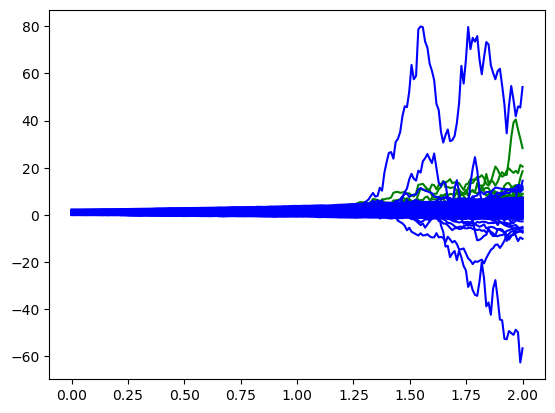

In [1260]:
# simulations of different things to see how the motion works
torch.manual_seed(0)
ys = []
ts = torch.linspace(0, 2.0, 200)
y0 = torch.tensor(0.)
sde = GPFIMotion()
#for p in sde.parameters():
    #p.requires_grad = False
# zs, logpy = sde(ts, batch_size = )
#sde(ts, 200)
with torch.no_grad():
    ys = sde(ts, 200)
ts, ys_target, ht = get_data()
plt.plot(ts, ys_target.T, color = "green")
plt.plot(ts, ys.squeeze().detach(), color = "blue")
plt.show()

In [1263]:
# more variance testing between fbm and fim
var_test = ys.reshape(200,200)
print(torch.var(var_test[199]))
print(torch.var(ys_target.T[199]))
print(sde.path_var)

tensor(39.0482)
tensor(10.2831)
tensor([[0.]])


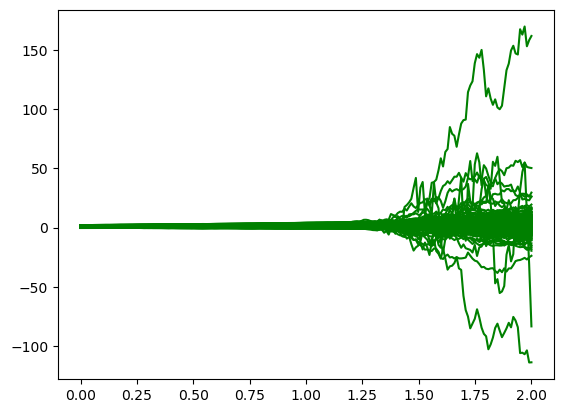

In [1268]:
torch.manual_seed(42)
with torch.no_grad():
    ys = sde(ts, 2000)
plt.plot(ts, ys.squeeze().detach(), color = "green")
plt.show()

In [1276]:
class ConstantNoise(SparseGPNoise):
    def compute_hurst(self, t):
        t = t.view(-1, 1)
        return torch.tensor(0.7)


def get_data():

    t0, t1 = 0.0, 2.0
    batch_size = 200

    x0 = 1
    alpha = 1
    beta = 1
    true_wn = ConstantNoise(t0=t0, t1=t1, dt=1e-2, num_steps=500, num_inducings=50)

    true_wn.precompute(batch_size=2000)

    ts, B_h, _ = true_wn.sample_alternative(2000)

    ht = torch.stack(
        [true_wn.compute_hurst(t) for t in ts], dim=0
    )  # t_size, 1, state_size

    # the exact solution
    X_t = B_h
    X_t = X_t.squeeze().transpose(0, 1)

    return ts, X_t, ht

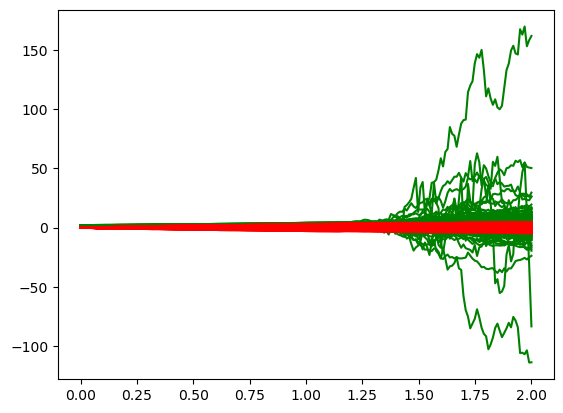

In [1279]:
# hmm... not sure what's happening here
ts, ys_const, ht = get_data()
plt.plot(ts, ys.squeeze().detach(), color = "green")
plt.plot(ts, ys_const.T, color = "red")

plt.show()

In [ ]:
# more simulations (earlier version of GPFIMotion)
from matplotlib import pyplot as plt
plt.figure()
for i in range(200):
    if i%2 == 0:
        plt.plot(ts, ys[i].squeeze().detach(), color = "green") # h < .5
    else:
        plt.plot(ts, ys[i].squeeze().detach(), color = "green") # h > .5
plt.xlabel('$t$')
plt.show()

In [853]:
ys_matrix = torch.concat(ys)
var = torch.var(ys_matrix, dim = -1)

In [1105]:
# computation graph
import torchview
from torchview import draw_graph
import graphviz
sde = GPFIMotion()
graphviz.set_jupyter_format('png')
model_graph = draw_graph(sde, input_data = (ts[1:2], 200), expand_nested=False)
graph = model_graph.visual_graph

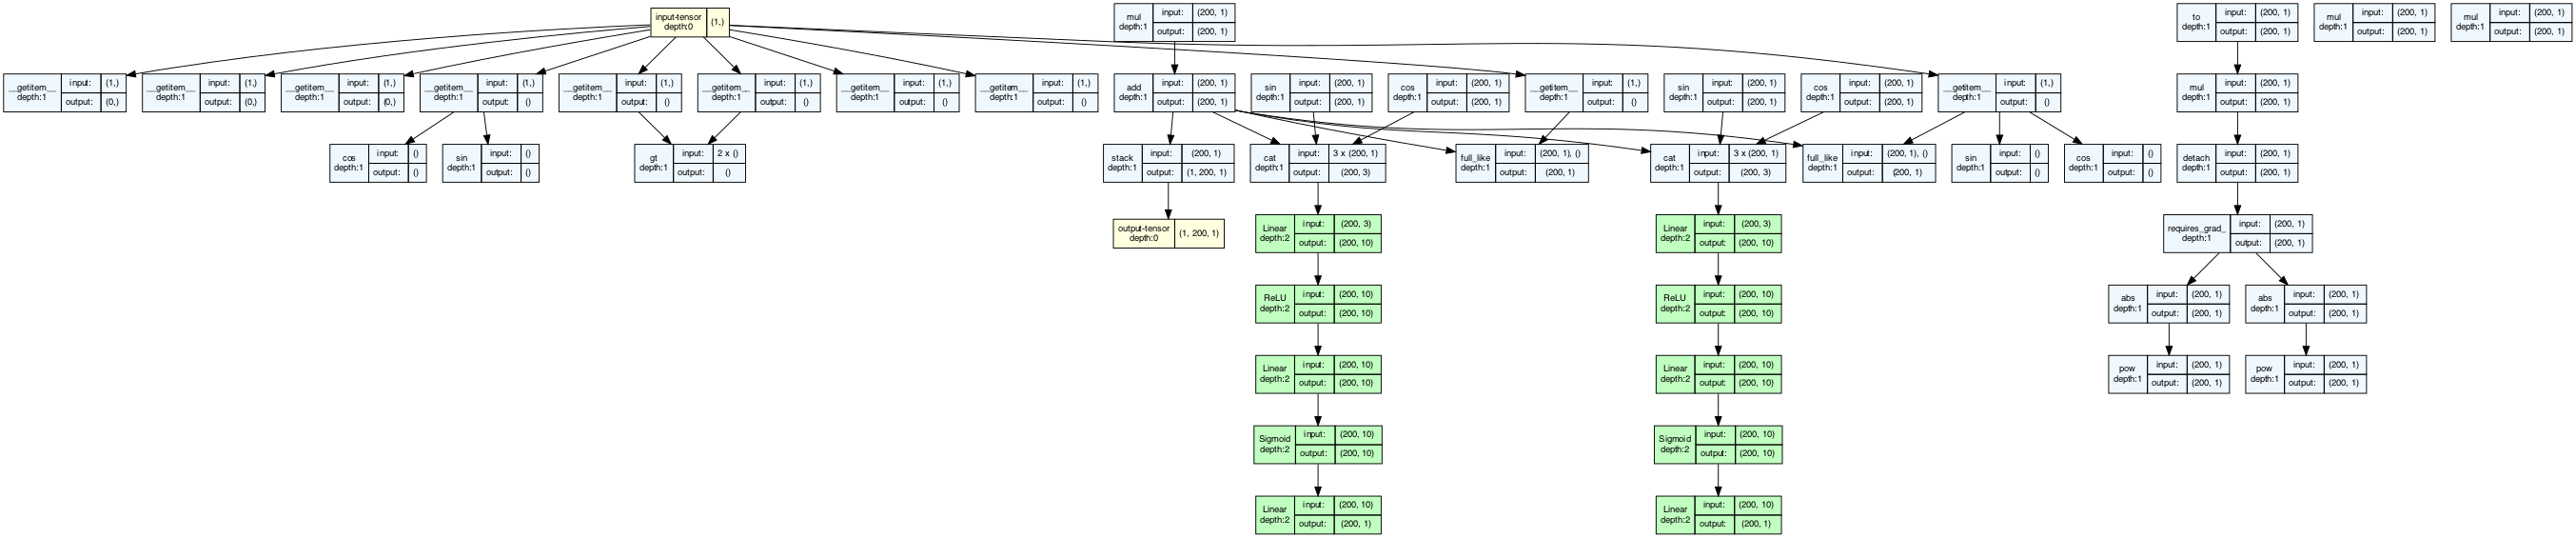

In [1106]:
graph

In [ ]:
torch.exp(torch.distributions.Normal(loc = 0, scale = torch.tensor(1).repeat(100,1)).log_prob(torch.randn(100,1)))/torch.exp(torch.distributions.Normal(loc = 0, scale = 1).log_prob(torch.tensor(0)))

In [891]:
# checking variance at different points of sde again
base = torch.concat([ys[0].reshape(-1,1), ys[1].reshape(-1,1)], dim = -1)
for i in range(499):
    ind = i+1
    base = torch.concat([base, ys[i].reshape(-1,1)], dim = -1)